# Introduction

The notebook is intended to analyse the weather outside conditions to find correlations with the inside air pollutions.

[Data](https://opendata.swiss/en/dataset/stundlich-aktualisierte-meteodaten-seit-1992)

For Sensirion data, we can not use information coming from Room A because the sensor stopped work from end of March on. Interpolating 5 months of data is unrealistically accurate.

In [1]:
# Import Standard Libraries
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

import seaborn as sns

from functools import reduce

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pickle

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Notebook's variables
weather_2022_data_file = './../data/ugz_ogd_meteo_h1_2022.csv'
sensirion_data_file = './../data/20220915_HackZurich_Sensirion_v1.csv'
model_file = './../model/co2_estimator.sav'

# Read Data

In [4]:
# Read precipitation data
weather_2022_data = pd.read_csv(weather_2022_data_file,
                                parse_dates=['Datum'])

sensirion_data = pd.read_csv(sensirion_data_file, 
                             parse_dates=['Unnamed: 0'])

# Fix Datetime
weather_2022_data['Datum'] = weather_2022_data['Datum'].apply(lambda row: row.replace(tzinfo=None))

# Rename columns
sensirion_data.rename(columns={'Unnamed: 0': 'Datum', 'consumed_meals': 'people'}, inplace=True)

In [5]:
weather_2022_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Datum      136950 non-null  datetime64[ns]
 1   Standort   136950 non-null  object        
 2   Parameter  136950 non-null  object        
 3   Intervall  136950 non-null  object        
 4   Einheit    136950 non-null  object        
 5   Wert       136476 non-null  float64       
 6   Status     136950 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 7.3+ MB


In [6]:
sensirion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69985 entries, 0 to 69984
Data columns (total 31 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Datum                                                  69985 non-null  datetime64[ns]
 1   temperature_ventilation_system_fresh_air_in            50974 non-null  float64       
 2   temperature_ventilation_system_fresh_air_intermediate  50974 non-null  float64       
 3   temperature_ventilation_system_fresh_air_out           50974 non-null  float64       
 4   temperature_ventilation_system_used_air_in             50974 non-null  float64       
 5   temperature_ventilation_system_used_air_out            50974 non-null  float64       
 6   volumne_flow_ventitaltion_system_in                    50974 non-null  float64       
 7   particulate_matter_outdoor_measured                    69780 non-nu

In [7]:
weather_2022_data.head()

,Datum,Standort,Parameter,Intervall,Einheit,Wert,Status
0,2022-01-01,Zch_Stampfenbachstrasse,T,h1,°C,7.22,provisorisch
1,2022-01-01,Zch_Stampfenbachstrasse,Hr,h1,%Hr,82.93,provisorisch
2,2022-01-01,Zch_Stampfenbachstrasse,p,h1,hPa,977.20,provisorisch
3,2022-01-01,Zch_Stampfenbachstrasse,RainDur,h1,min,0.00,provisorisch
4,2022-01-01,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.02,provisorisch


In [8]:
sensirion_data.head()

,Datum,temperature_ventilation_system_fresh_air_in,temperature_ventilation_system_fresh_air_intermediate,temperature_ventilation_system_fresh_air_out,temperature_ventilation_system_used_air_in,temperature_ventilation_system_used_air_out,volumne_flow_ventitaltion_system_in,particulate_matter_outdoor_measured,temperature_outdoor,humidity_outdoor_measured,...,co2_room_A,co2_room_B,particulate_matter_room_A,tvoc_room_A,temperature_room_B,humidity_room_B,particulate_matter_room_B,no2_room_B,tvoc_room_B,people
0,2021-05-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.382250,6.8924,42.4059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2021-05-02 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,0.379375,6.9073,42.3694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2021-05-02 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,0.474375,6.8834,42.3726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2021-05-02 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,0.402085,6.8325,42.4241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2021-05-02 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,0.346685,6.8003,42.4528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


# Exploratory Data Analysis

## NaN Values

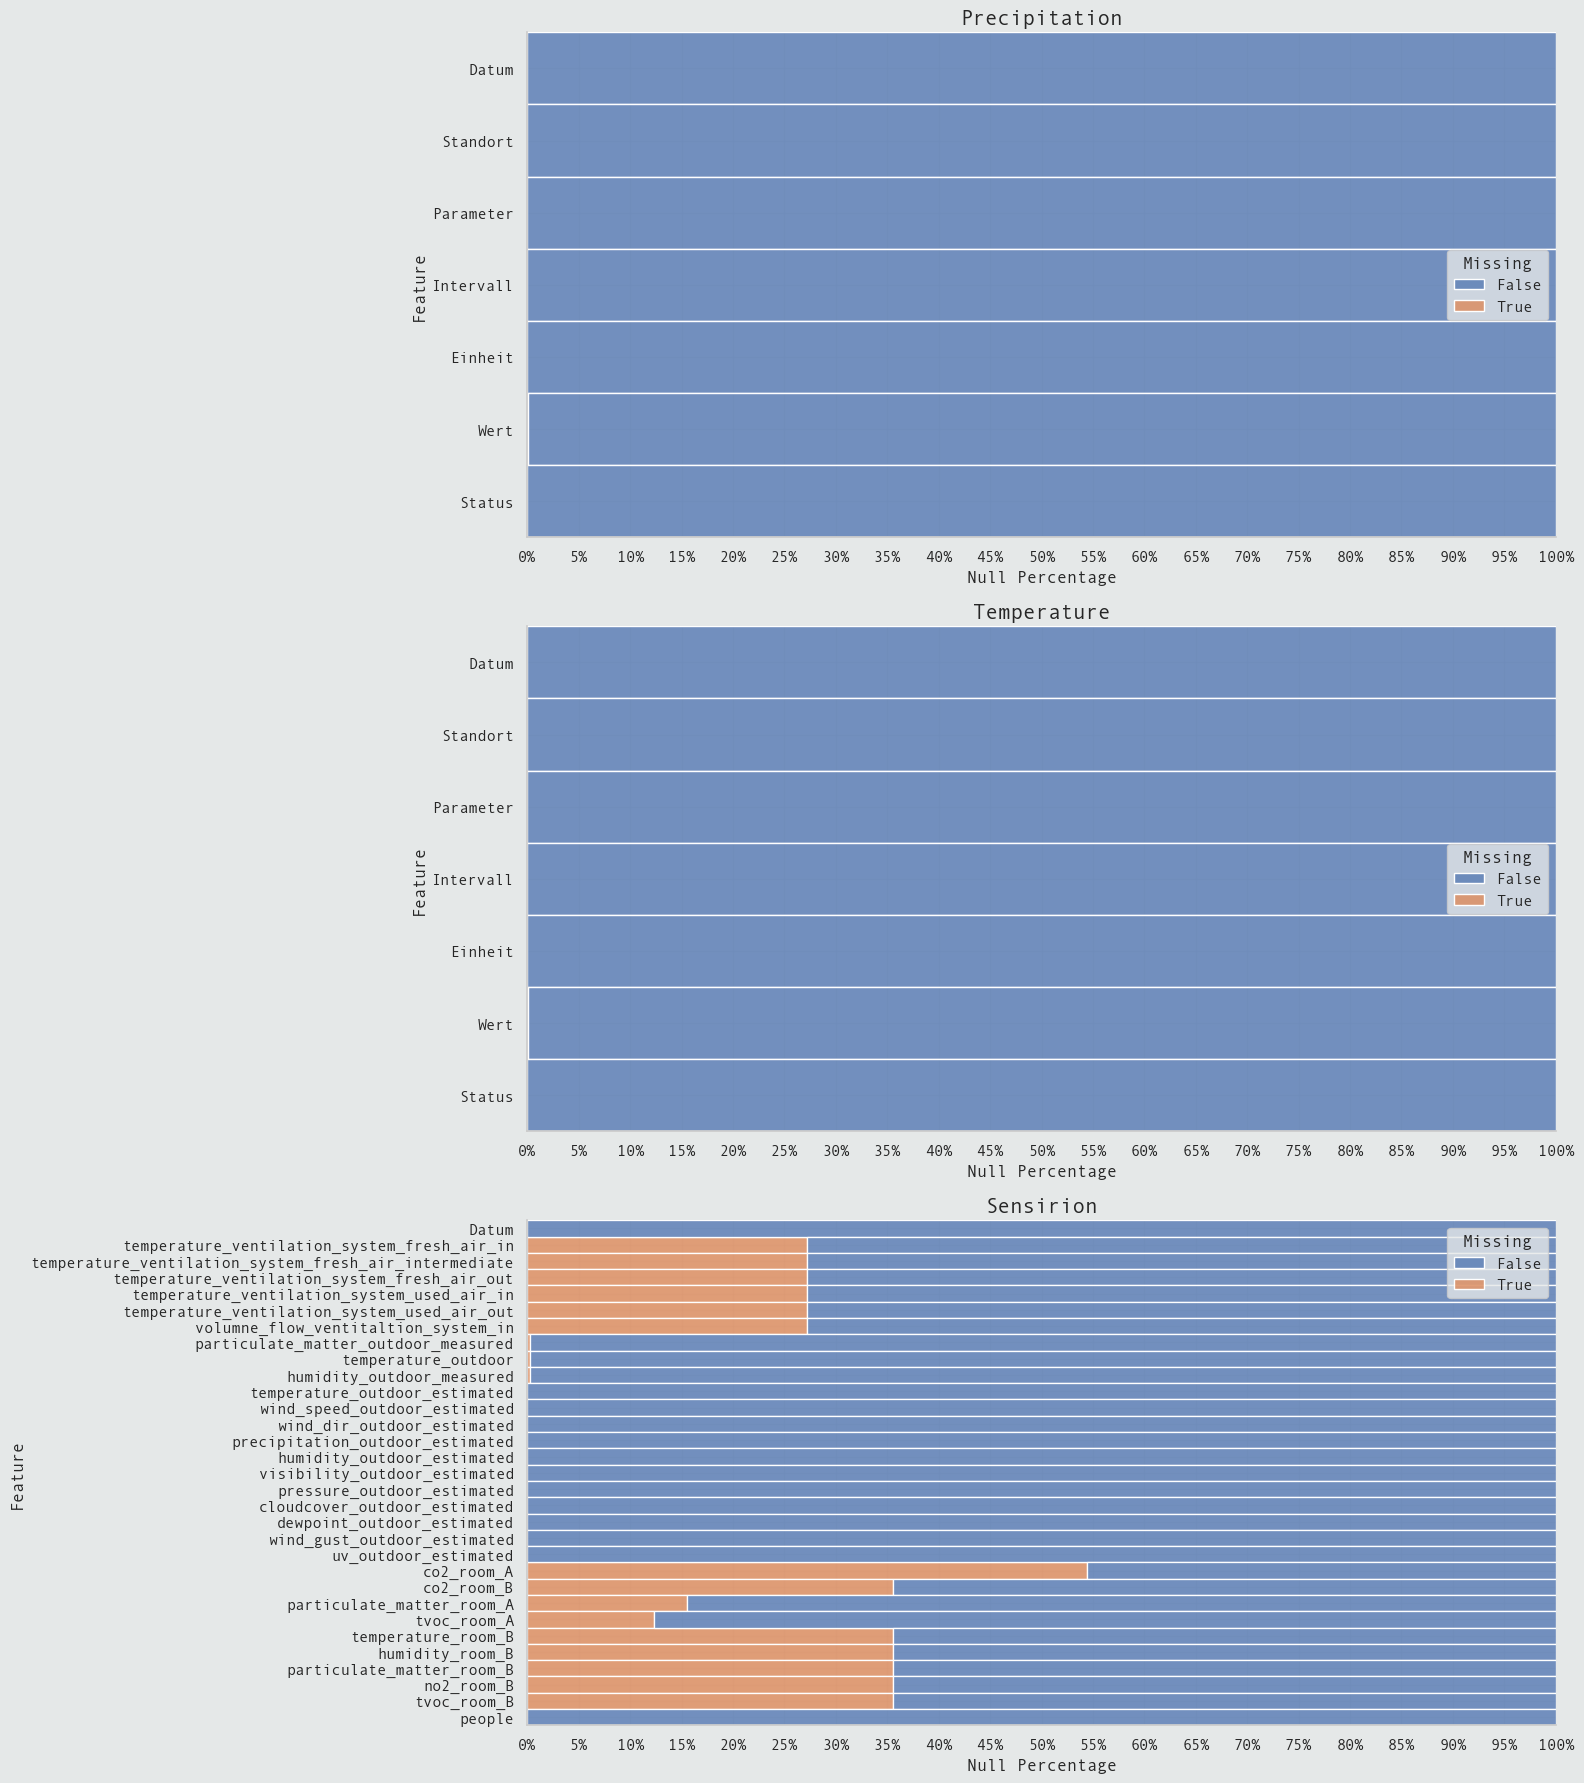

In [9]:
# Define data to display
data_to_display = {
    'Precipitation': weather_2022_data[weather_2022_data['Parameter'] == 'RainDur'],
    'Temperature': weather_2022_data[weather_2022_data['Parameter'] == 'T'],
    'Sensirion': sensirion_data
}

# Create figure
figure = plt.figure(tight_layout=True, figsize=(16, 18))

# Define figure's subplots
grid_spec = GridSpec(len(data_to_display), 1)

# Fetch data to plot
for row, (name, dataframe) in enumerate(data_to_display.items()):
    
    # Create subplot
    ax = figure.add_subplot(grid_spec[row, 0])
    
    sns.histplot(data=dataframe.isna().melt(var_name='Feature', value_name='Missing'), 
                 y='Feature', 
                 hue='Missing', 
                 multiple='fill',
                 ax=ax)
    
    # Refactor x label as missing percentage
    ax.xaxis.set_major_locator(ticker.LinearLocator(21))
    ax.xaxis.set_major_formatter('{:.0%}'.format)
    
    # Set title and label
    ax.set_title(name, fontsize=15)
    ax.set_xlabel('Null Percentage')

## Precipitations over Time

In [10]:
# Retrieve only precipitations
precipitations_2022 = weather_2022_data[weather_2022_data['Parameter'] == 'RainDur']

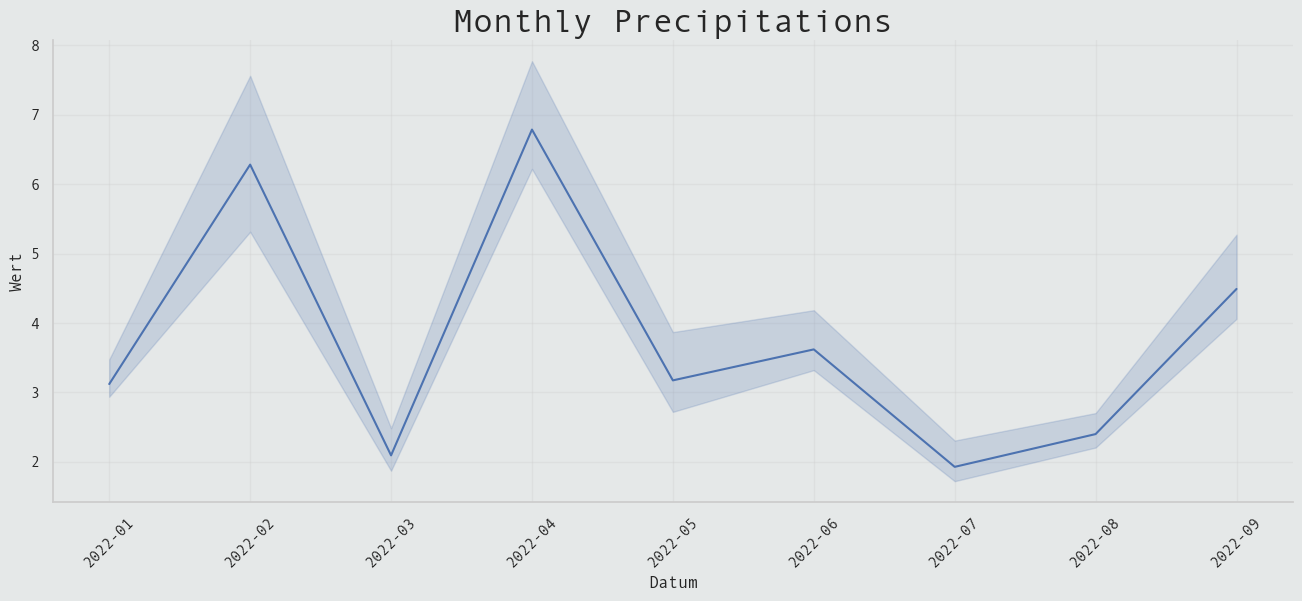

In [11]:
ax = sns.lineplot(
    data=precipitations_2022.groupby([
        precipitations_2022.Datum.dt.strftime('%Y-%m'),
        precipitations_2022.Standort
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert'
)

ax.set_title('Monthly Precipitations')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

plt.show()

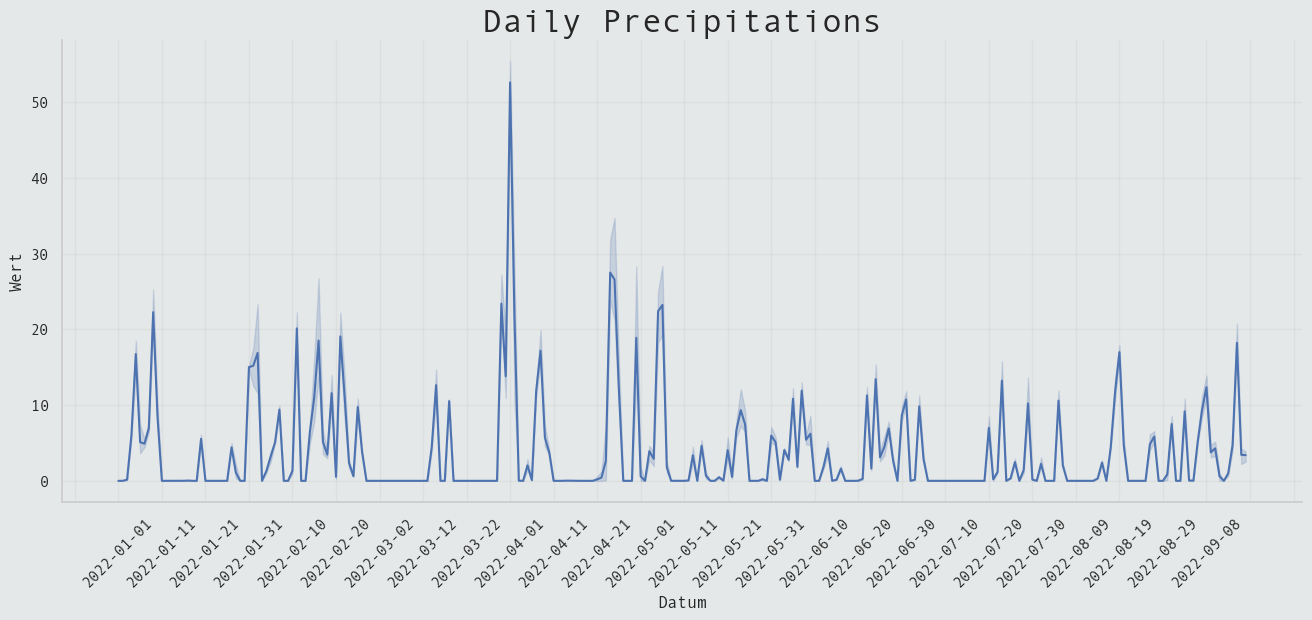

In [12]:
ax = sns.lineplot(
    data=precipitations_2022.groupby([
        precipitations_2022.Datum.dt.strftime('%Y-%m-%d'),
        precipitations_2022.Standort
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert'
)

ax.set_title('Daily Precipitations')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))

plt.show()

## Temperature over Time

In [13]:
# Retrieve only temperatures
temperatures_2022 = weather_2022_data[weather_2022_data['Parameter'] == 'T']

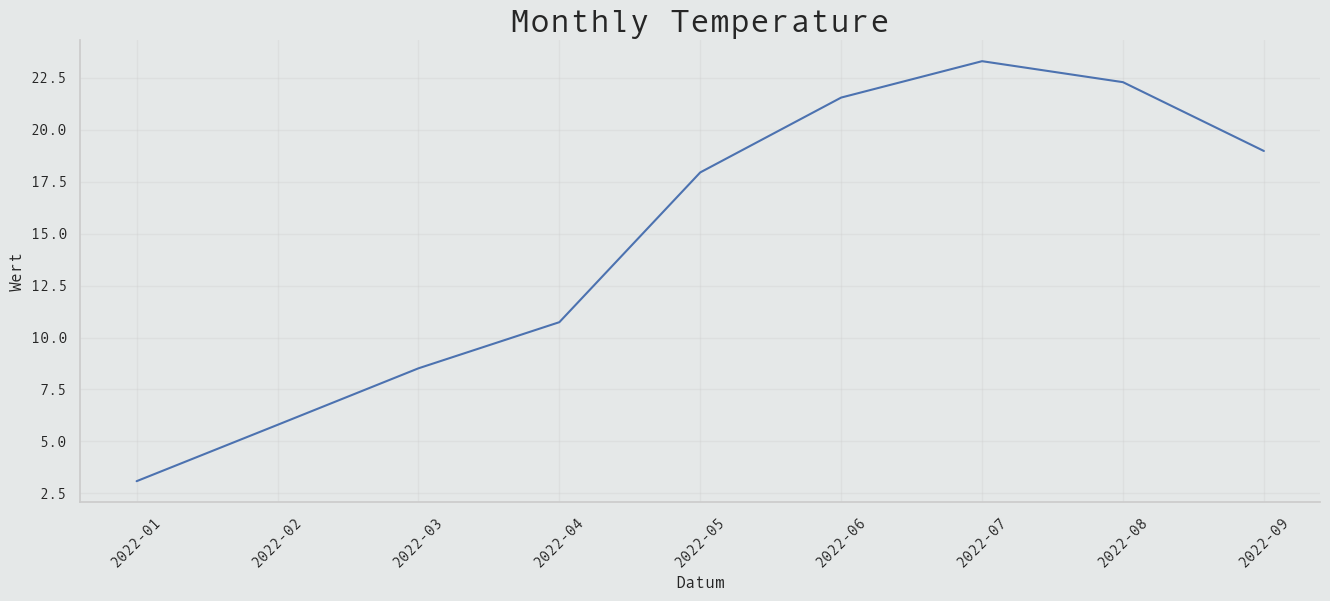

In [14]:
ax = sns.lineplot(
    data=temperatures_2022.groupby([
        temperatures_2022.Datum.dt.strftime('%Y-%m')
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert', 
)

ax.set_title('Monthly Temperature')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

plt.show()

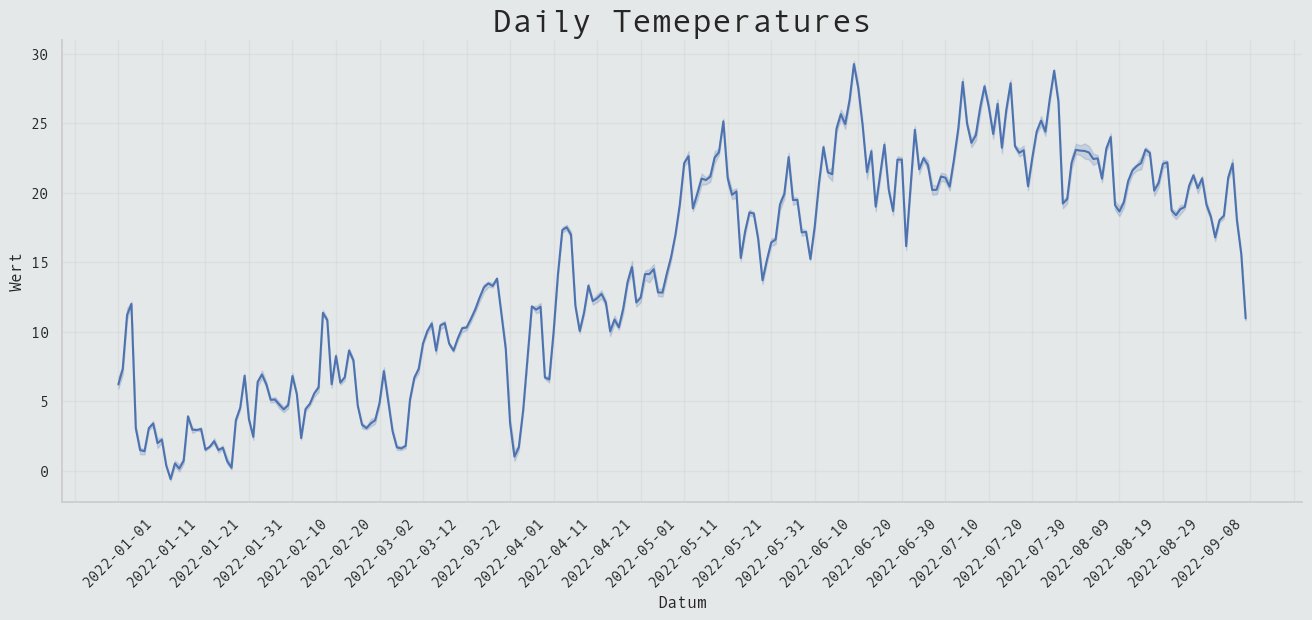

In [15]:
ax = sns.lineplot(
    data=temperatures_2022.groupby([
        temperatures_2022.Datum.dt.strftime('%Y-%m-%d'),
        temperatures_2022.Standort
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert'
)

ax.set_title('Daily Temeperatures')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))

plt.show()

## Daily Precipitations & Temepratures

In [16]:
# Retrieve only precipitations & temperatures
precipitations_temperatures_2022 = weather_2022_data[(weather_2022_data['Parameter'] == 'RainDur') | (weather_2022_data['Parameter'] == 'T')]

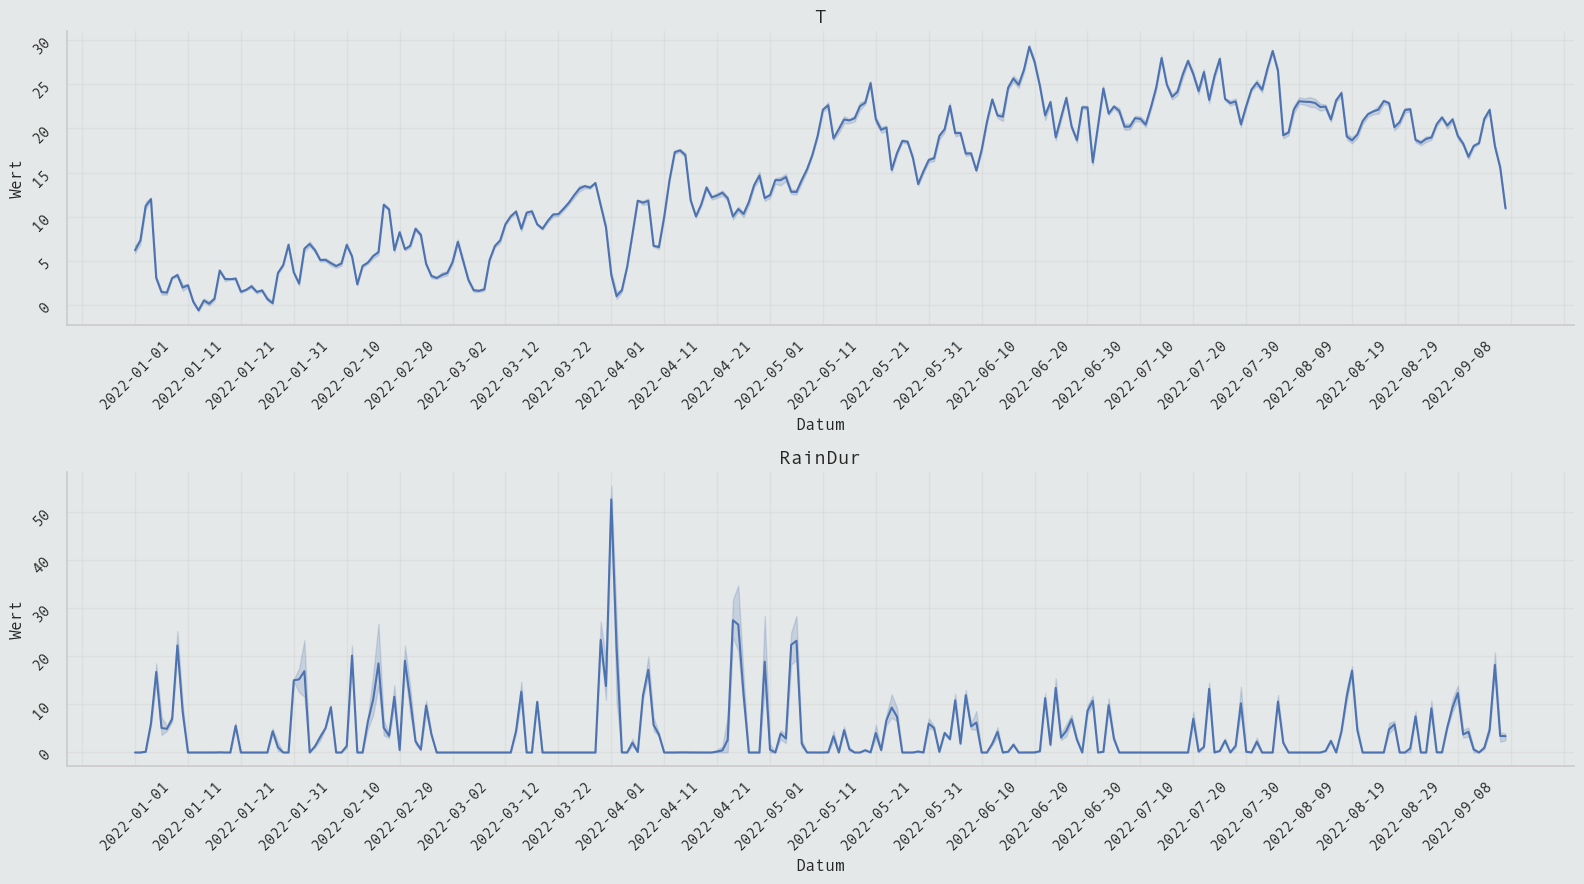

In [17]:
# Define the subplot
figure, ax = plt.subplots(2, 1, figsize=(16, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, parameter in enumerate(precipitations_temperatures_2022['Parameter'].unique()):
    
    # Retrieve the data to plot
    data_plot = precipitations_temperatures_2022[precipitations_temperatures_2022['Parameter'] == parameter]
    
    # Define the plot
    sns.lineplot(data=data_plot.groupby([
                        data_plot.Datum.dt.strftime('%Y-%m-%d'), 
                        data_plot.Standort
                        ])['Wert'].mean().reset_index(), 
                 x='Datum', 
                 y='Wert', 
                 ax=ax[index])
    
    # Set the title
    ax[index].set_title(parameter, fontsize=14)
    ax[index].xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
    
    ax[index].tick_params(labelrotation=45)
    
plt.tight_layout()

## CO2 Room B over Time

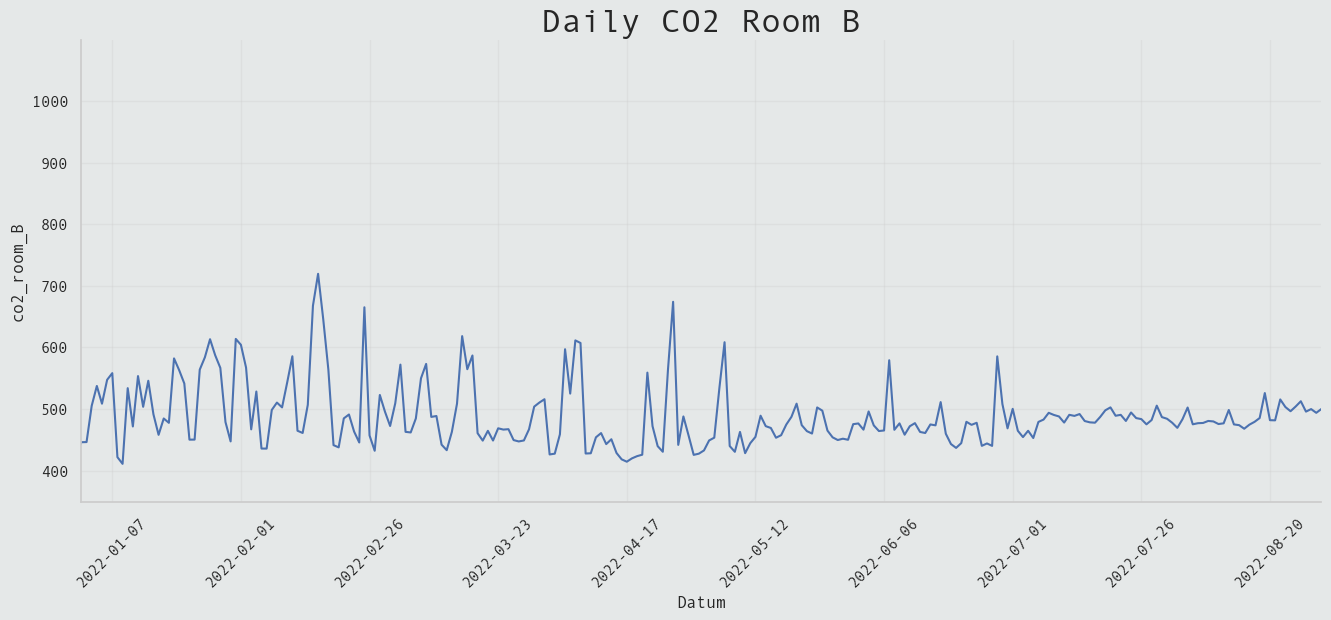

In [18]:
ax = sns.lineplot(
    data=sensirion_data.groupby([
        sensirion_data.Datum.dt.strftime('%Y-%m-%d')    
    ])['co2_room_B'].mean().reset_index(), 
    x='Datum', 
    y='co2_room_B'
)

ax.set_title('Daily CO2 Room B')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

plt.xlim(['2022-01-01', '2022-08-30'])

plt.show()

## Number of People over Time

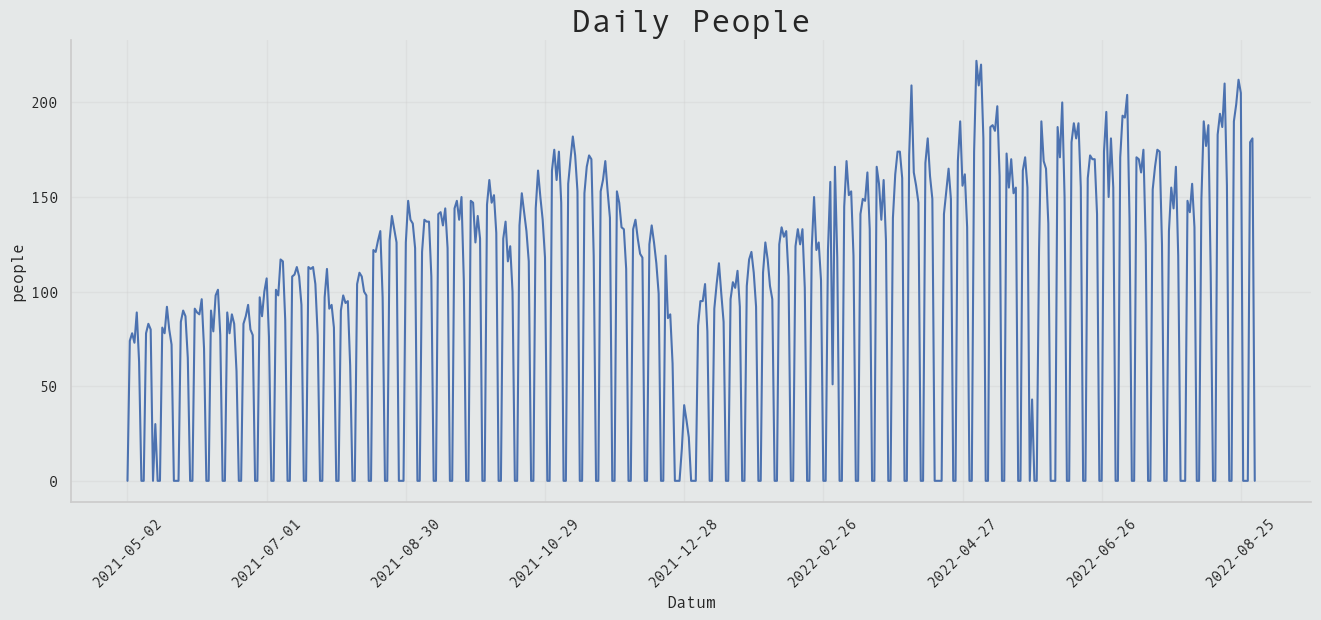

In [19]:
ax = sns.lineplot(
    data=sensirion_data.groupby([
        sensirion_data.Datum.dt.strftime('%Y-%m-%d')    
    ])['people'].sum().reset_index(), 
    x='Datum', 
    y='people'
)

ax.set_title('Daily People')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

plt.show()

# Data Pre-processing

## Create Dataset

In [20]:
# Aggregate Weather data per Standort with the mean
precipitations_2022_aggregated_standort = precipitations_2022.groupby(['Datum'])['Wert'].mean().reset_index()
precipitations_2022_aggregated_standort.rename(columns={'Datum': 'Datum', 'Wert': 'Precipitation'}, inplace=True)

temperatures_2022_aggregated_standort = temperatures_2022.groupby(['Datum'])['Wert'].mean().reset_index()
temperatures_2022_aggregated_standort.rename(columns={'Datum': 'Datum', 'Wert': 'Temperature'}, inplace=True)

In [21]:
# Aggregate Sensirion data per yyyy/mm/dd
sensirion_data['Datum'] = pd.to_datetime(sensirion_data['Datum'].dt.to_period('D').astype(str))
people_aggregated_day = sensirion_data.groupby(['Datum'])['people'].sum().reset_index()
co2_room_a_aggregated_day = sensirion_data.groupby(['Datum'])['co2_room_B'].mean().reset_index()

In [22]:
# Since 'people' are between Room A and B, let's take 45% of them and consider them for Room B only
people_aggregated_day['people'] = people_aggregated_day['people'].apply(lambda row: round(row * 45 / 100, 2))

In [23]:
# Create the dataset
dataframes = [precipitations_2022_aggregated_standort, temperatures_2022_aggregated_standort, people_aggregated_day, co2_room_a_aggregated_day]
dataset = reduce(lambda left,right: pd.merge(left,right,on=['Datum'], how='inner'), dataframes)
dataset.rename(columns={'Datum': 'datum', 'Precipitation': 'precipitation', 'Temperature': 'temperature'}, inplace=True)

In [24]:
dataset.sample(5)

,datum,precipitation,temperature,people,co2_room_B
110,2022-04-21,0.00,10.070000,74.25,559.139536
72,2022-03-14,0.00,10.966667,63.45,462.935723
219,2022-08-08,0.00,18.930000,67.05,480.643398
174,2022-06-24,0.11,19.533333,63.45,477.657859
106,2022-04-17,0.00,8.380000,0.00,414.477074


## Engineer Date

In [25]:
# Compute 'day', 'month' and 'dayofweek'
dataset['datum_day'] = dataset['datum'].dt.day
dataset['datum_month'] = dataset['datum'].dt.month
dataset['datum_dayofweek'] = dataset['datum'].dt.dayofweek

## Remove Weekends

We are not interested in weekends, since people are not going to work on those days.

In [26]:
# Remove Saturdays and Sundays
dataset_no_we = dataset[(dataset['datum_dayofweek'] != 5) & (dataset['datum_dayofweek'] != 6)].reset_index()

## Features & Labels Definition

In [27]:
# Define features
features = ['precipitation', 
            'temperature', 
            'people', 
            'datum_day', 
            'datum_month', 
            'datum_dayofweek']

label = ['co2_room_B']

## Numerical Features

In [28]:
# Numerical features pipeline
numerical_features_pipeline = Pipeline(steps=[
    ('numerical_scaler', StandardScaler())
])

## Bundle Data Preprocessing Steps

In [29]:
# Bunlde data preprocessing steps
data_preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_preprocessing', numerical_features_pipeline, features)
    ])

## Train & Test Split

In [30]:
# Define X and y for the training set
X = dataset_no_we[features]
y = dataset_no_we[label]

In [31]:
# Split training data into train and validation
X_train = X[X['datum_month'] != 8]
y_train = y.iloc[X_train.index]
X_test = X[X['datum_month'] == 8]
y_test = y.iloc[X_test.index]

# Model

## Linear Regression

In [32]:
%%time

# Define the model
model_lr = LinearRegression()

# Define the pipeline
pipe_lr = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('linear_regression', model_lr)
])

# Train the pipeline
pipe_lr.fit(X_train, 
            y_train)

# Get number of sold predictions
predictions_lr = pipe_lr.predict(X_test)

# Model evaluation
mse_lr = round(mean_squared_error(y_test, predictions_lr), 2)

print('MSE: {}'.format(mse_lr))
print('\n')

MSE: 1692.58


CPU times: user 12.5 ms, sys: 1.04 ms, total: 13.5 ms
Wall time: 13.2 ms


# Save Model

In [33]:
# Save the model as Pickle file
pickle.dump(pipe_lr, open(model_file, 'wb'))